## Example 1: Fully visible two-body decay
The results from this notebook are used in [2105.10126 [hep-ph]](https://arxiv.org/abs/2105.10126).

#### Software versions (used to make the plots in the paper)
  * Python: 3.8.10
    * numpy: 1.19.5
    * scipy: 1.6.1
    * matplotlib: 3.4.2
    * tensorflow: 2.5.0

**Optional:** Set `usejournalfonts = True` to use the same fonts used in the journal template. This has additional LaTeX and Ghostscript requirements. Set `usejournalfonts = False` to use the regular matplotlib fonts.

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

import phasespacegen as psg

## Code block to print the Python and package versions
print_versions = False
if print_versions:
    import platform
    print("Software versions")
    print(f"  * Python: {platform.python_version()}")
    print(f"    * numpy: {np.__version__}")
    print(f"    * scipy: {scipy.__version__}")
    print(f"    * matplotlib: {mpl.__version__}")
    print(f"    * tensorflow: {tf.__version__}")

**Note**: Setting `usejournalfonts` to `True` has additional software requirements (see above).

In [2]:
usejournalfonts = True

if usejournalfonts: # Slow and has additional software requirements
    default_fontsize = 23
    mpl.rc('text', usetex=usejournalfonts)
    mpl.rc('text.latex', preamble=r'\usepackage{amsfonts}')
    mpl.rc('font', family='sans-serif')
    
    import subprocess
    import shutil
    def compress_pdf(fname):
        tmp_fname = fname.rsplit('.', 1)[0] + "_ghostscript.pdf"
        subprocess.run(['gswin64', '-sDEVICE=pdfwrite', '-dPDFSETTINGS=/printer', '-dEmbedAllFonts=true',
                        '-dNOPAUSE', '-dQUIET', '-dBATCH', '-sOutputFile='+tmp_fname, fname])
        shutil.move(tmp_fname, fname)
else: #Faster
    default_fontsize = 20
        
plt.rcParams.update({'font.size': default_fontsize})

# Wrapper for plt.savefig ########################
def save_figure(pltobj, fname):
    _ = pltobj.savefig(fname, bbox_inches='tight')
    if usejournalfonts:
        compress_pdf(fname)
    return _
##################################################

class ScalarFormatterForceFormat(ScalarFormatter):
    def __init__(self, fmt):
        if usejournalfonts:
            self.__fmtstring = f'${fmt}$'
        else:
            self.__fmtstring = fmt
        super().__init__()
    def _set_format(self):
        self.format = self.__fmtstring

#### Some config.

In [3]:
N_train_class0 = N_train_class1 = 1_250_000
N_test_heatmap = 100_000
N_test_1dhists = 10_000

event_dim = 8
bottleneck_dim = 1
param_dim = 1

theory_event_var_label = r"$m_{bc}$ (GeV)"

### Data generation routines
A custom module called `phasespacegen`, imported as `psg`, is used for simulating the on-shell decay of particles.

In [4]:
M0_range = [100, 500]
E0_range = [100, 1500]
m_range = [0, 0]

assert E0_range[1] >= M0_range[1]
assert 2*m_range[0] <= M0_range[0]

def param_gen(N, rng):
    # Generate parent mass
    return rng.uniform(M0_range[0], M0_range[1], size=(N, 1))

def event_gen(params, rng):
    M0 = params
    N = len(M0)
    
    # Generate parent energy, direction
    E0 = rng.uniform(np.maximum(E0_range[0], M0), E0_range[1], size=(N, 1))
    dir0 = rng.standard_normal(size=(N, 3))
    dir0 /= np.linalg.norm(dir0, axis=-1, keepdims=True)
    
    # Generate children masses
    m1 = rng.uniform(m_range[0], np.minimum(M0-m_range[0], m_range[1]), size=(N,1))
    m2 = rng.uniform(m_range[0], np.minimum(M0-m1, m_range[1]), size=(N,1))
    
    is_swap = rng.integers(0, 1, endpoint=True)
    m1, m2 = np.choose(is_swap, [m1, m2]), np.choose(is_swap, [m2, m1])
    
    # Decay the particles ######################################
    parent = psg.Particle(mass=M0, energy=E0, dir=dir0)
    child1, child2 = parent.decay(m1, m2, rng) # rng is needed to sample the decay directions
    
    # sanity checks
    assert np.allclose(child1.p_4vec + child2.p_4vec, parent.p_4vec, rtol=1e-9)
    
    for particle in [parent, child1, child2]:
        assert np.all(particle.energy > particle.mass*(1-1e-9))
        assert np.allclose(particle.mass**2, particle.energy**2 - np.sum(particle.p_3vec**2, axis=-1, keepdims=True), rtol=1e-9)
    
    # Visible event information
    events = np.concatenate([child1.p_4vec, child2.p_4vec], axis=-1)
    return events

### Function to compute the theoretical event variable

In [5]:
def theory_var(events):
    p_4vec = events[:,:4] + events[:,4:]
    invariant_mass = (p_4vec[:,0]**2 - p_4vec[:,1]**2 - p_4vec[:,2]**2 - p_4vec[:,3]**2)**.5
    
    return invariant_mass

### Training and testing (for heatmap) data generation

In [6]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

class0_params = param_gen(N_train_class0, rng)
class0_events = event_gen(param_gen(N_train_class0, rng), rng)
class0_ytarget = np.zeros(shape=(N_train_class0, 1))

class1_params = param_gen(N_train_class1, rng)
class1_events = event_gen(class1_params, rng)
class1_ytarget = np.ones(shape=(N_train_class1, 1))

permutation = rng.permutation(N_train_class0 + N_train_class1)
params_train = np.concatenate([class0_params, class1_params])[permutation]
events_train = np.concatenate([class0_events, class1_events])[permutation]
ytarget_train = np.concatenate([class0_ytarget, class1_ytarget])[permutation]

events_test = event_gen(param_gen(N_test_heatmap, rng), rng)

In [7]:
assert events_train.shape[1] == event_dim
assert params_train.shape[1] == param_dim

### Creating the Artificial Event Variable Network

In [8]:
tf.random.set_seed(0)

# Artificial Event Variable Network
AEV_network = tf.keras.Sequential(name="event_variable")
AEV_network.add(tf.keras.layers.InputLayer(input_shape=(event_dim,)))

hidden_node_counts = [128, 64, 64, 64, 32]
for node_count in hidden_node_counts:
    AEV_network.add(tf.keras.layers.Dense(node_count, activation='relu'))

AEV_network.add(tf.keras.layers.Dense(bottleneck_dim, activation=None))

AEV_network.summary()

Model: "event_variable"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 19,841
Trainable params: 19,841
Non-trainable params: 0
________________________________________________

### Creating the auxiliary classifier network

In [9]:
classifier_network = tf.keras.Sequential(name="classifier")
classifier_network.add(tf.keras.layers.InputLayer(input_shape=(param_dim+bottleneck_dim,)))

hidden_node_counts = [16, 16, 16]
for node_count in hidden_node_counts:
    classifier_network.add(tf.keras.layers.Dense(node_count, activation='relu'))

classifier_network.add(tf.keras.layers.Dense(1, activation='sigmoid'))

classifier_network.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


### Combining the two networks into a trainable composite network

In [10]:
param_input_tensor = tf.keras.Input(shape=(param_dim,), name='param_input')
event_input_tensor = tf.keras.Input(shape=(event_dim,), name='event_input')

AEV_output_tensor = AEV_network(event_input_tensor)
classifier_input_tensor = tf.keras.layers.concatenate([param_input_tensor, AEV_output_tensor])

classifier_output_tensor = classifier_network(classifier_input_tensor)

model = tf.keras.Model(
    inputs = [param_input_tensor, event_input_tensor],
    outputs = classifier_output_tensor
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_input (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
param_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
event_variable (Sequential)     (None, 1)            19841       event_input[0][0]                
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           param_input[0][0]                
                                                                 event_variable[0][0]         

#### Code-block to restore saved models from disk

In [11]:
# ## Restore saved models ##########################
# ## Load component networks #############
# AEV_network = tf.keras.models.load_model("saved_models/example1_AEV_network.h5")
# classifier_network = tf.keras.models.load_model("saved_models/example1_classifier_network.h5")

# ## Re-create meta network #################
# param_input_tensor = tf.keras.Input(shape=(param_dim,), name='param_input')
# event_input_tensor = tf.keras.Input(shape=(event_dim,), name='event_input')

# AEV_output_tensor = AEV_network(event_input_tensor)
# classifier_input_tensor = tf.keras.layers.concatenate([param_input_tensor, AEV_output_tensor])

# classifier_output_tensor = classifier_network(classifier_input_tensor)

# model = tf.keras.Model(
#     inputs = [param_input_tensor, event_input_tensor],
#     outputs = classifier_output_tensor
# )

### Training the composite network

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
model.fit(x=[params_train, events_train], y=ytarget_train, batch_size=50, epochs=20, validation_split=0.2)

Epoch 1/20
40000/40000 [==============================] - 43s 1ms/step - loss: 0.3667 - val_loss: 0.2602
Epoch 2/20
40000/40000 [==============================] - 53s 1ms/step - loss: 0.2725 - val_loss: 0.2613
Epoch 3/20
40000/40000 [==============================] - 52s 1ms/step - loss: 0.2492 - val_loss: 0.2438
Epoch 4/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.2352 - val_loss: 0.2472
Epoch 5/20
40000/40000 [==============================] - 56s 1ms/step - loss: 0.2242 - val_loss: 0.2292
Epoch 6/20
40000/40000 [==============================] - 56s 1ms/step - loss: 0.2163 - val_loss: 0.1905
Epoch 7/20
40000/40000 [==============================] - 57s 1ms/step - loss: 0.2113 - val_loss: 0.2302
Epoch 8/20
40000/40000 [==============================] - 54s 1ms/step - loss: 0.2058 - val_loss: 0.2153
Epoch 9/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.2025 - val_loss: 0.2134
Epoch 10/20
40000/40000 [==============================

#### Code-block to save models to disk

In [14]:
## Save models ###################################
AEV_network.save("saved_models/example1_AEV_network.h5")
classifier_network.save("saved_models/example1_classifier_network.h5")

### Compute the machine-learned variable and theory variable

In [15]:
artificial_event_var = AEV_network(events_test).numpy().squeeze()
theoretical_event_var = theory_var(events_test)

### Ensuring positive correlation

In [16]:
kendalltau = scipy.stats.kendalltau(artificial_event_var, theoretical_event_var).correlation
spearmanr = scipy.stats.spearmanr(artificial_event_var, theoretical_event_var).correlation

flip = False
if kendalltau < 0:
    flip = True
    kendalltau *= -1
    spearmanr *= -1
    artificial_event_var *= -1

print(f"{kendalltau = }")
print(f"{spearmanr = }")

kendalltau = 0.9525172068048503
spearmanr = 0.9970512396780095


### Heatmap showing the correlation between the machine-learned variable and theory variable

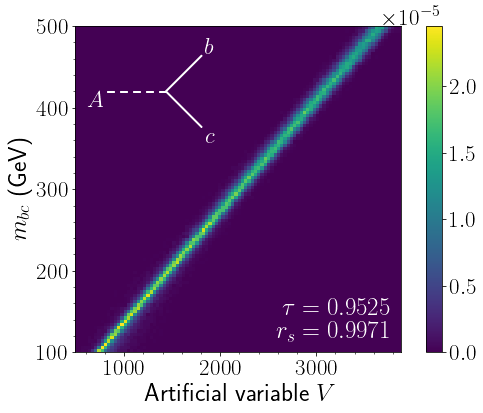

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))

_ = ax.hist2d(artificial_event_var, theoretical_event_var, bins=(100,100), density=True, rasterized=True)
cb_formatter = ScalarFormatterForceFormat('%1.1f')
cb_formatter.set_powerlimits((0, 0))
fig.colorbar(_[3], ax=ax, format=cb_formatter)

ax.set_xlabel(r"Artificial variable $V$", fontsize=default_fontsize+2)
ax.set_ylabel(theory_event_var_label, fontsize=default_fontsize+2)
ax.set_aspect(1/ax.get_data_ratio())

if kendalltau > 0:
    ax.text(.97, .10, f"$\\tau={kendalltau:.4f}$", color='white', transform=ax.transAxes, va='bottom', ha='right', fontsize=default_fontsize+2)
    ax.text(.97, .03, f"$r_s={spearmanr:.4f}$", color='white', transform=ax.transAxes, va='bottom', ha='right', fontsize=default_fontsize+2)
    x_start = .1
else:
    ax.text(.03, .10, f"$\\tau={kendalltau:.4f}$", color='white', transform=ax.transAxes, va='bottom', ha='left', fontsize=default_fontsize+2)
    ax.text(.03, .03, f"$r_s={spearmanr:.4f}$", color='white', transform=ax.transAxes, va='bottom', ha='left', fontsize=default_fontsize+2)
    x_start = .62

## Draw Feynman diagram ##########################
arrow_props = {'width': 3e-3, 'length_includes_head': False, 'head_width': 0, 'head_length': 0, 'color': 'white'}

for tmp in [x_start+_ for _ in [0, .04, .08, .12, .16]]:
    ax.arrow(tmp, .8, .02, 0, transform=ax.transAxes, **arrow_props)
ax.arrow(x_start+.18, .8, .11, .11, transform=ax.transAxes, **arrow_props)
ax.arrow(x_start+.18, .8, .11, -.11, transform=ax.transAxes, **arrow_props)

ax.text(x_start-.01, .8, r"$A$", color='white', transform=ax.transAxes, va='top', ha='right')
ax.text(x_start+.3, .9, r"$b$", color='white', transform=ax.transAxes, va='bottom', ha='left')
ax.text(x_start+.3, .69, r"$c$", color='white', transform=ax.transAxes, va='top', ha='left')
##################################################

ax.set_xticks(range(1000, 3001, 1000))
ax.set_yticks(range(100, 501, 100))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

save_figure(plt, "plots/example1_heatmap.pdf")

### 1d histograms

In [18]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

events_200 = event_gen(
    np.full(shape=(N_test_1dhists, 1), fill_value=200.),
    rng
)

events_280 = event_gen(
    np.full(shape=(N_test_1dhists, 1), fill_value=280.),
    rng
)

events_320 = event_gen(
    np.full(shape=(N_test_1dhists, 1), fill_value=320.),
    rng
)

events_400 = event_gen(
    np.full(shape=(N_test_1dhists, 1), fill_value=400.),
    rng
)

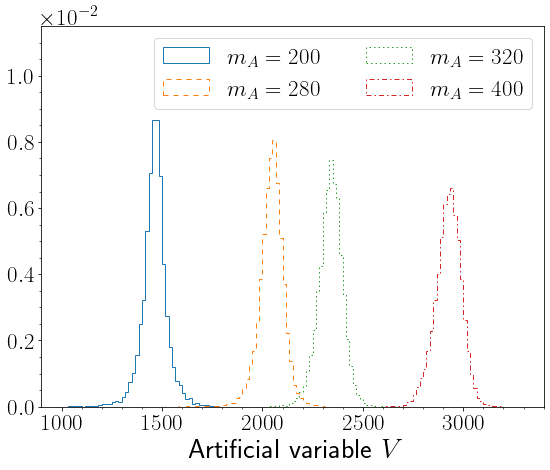

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))

xlims = (900, 3400)
bins = 150

data_list = [events_200, events_280, events_320, events_400]
linestyle_list = ['solid', (0, (5, 5)), (0, (1.5, 3)), (0, (5, 3, 1.5, 3))]
label_list = [r"$m_A = 200$", r"$m_A = 280$", r"$m_A = 320$", r"$m_A = 400$"]

for data, linestyle, label in zip(data_list, linestyle_list, label_list):
    ax.hist((-1 if flip else 1)*AEV_network(data).numpy().squeeze(), bins=bins, range=xlims, density=True,
        histtype='step', linestyle=linestyle, label=label)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

y_formatter = ScalarFormatterForceFormat('%1.1f')
y_formatter.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(y_formatter)

ax.set_ylim(0, .0115)
ax.set_xlim(*xlims)
ax.set_xlabel(r"Artificial variable $V$", fontsize=default_fontsize+5)
ax.legend(ncol=2)

save_figure(plt, "plots/example1_1dhists.pdf")